In [37]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime
from sklearn import metrics
from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer

def get_time_as_float(dt):
    ls = re.findall(r'[0-9]+', dt)
    ret = datetime(*[int(i) for i in ls]).timestamp()
    return ret

def transform_data(ls):
    ret = []
    for i in range(len(ls)):
        ret.append(get_time_as_float(ls[i]) if i == 0 else float(ls[i]))
    
    return ret

# Load Digit Data
data, target = load_digits(return_X_y = True)

# Load Occupancy Data
f = open('datatraining.txt', 'r')
lines = [line.strip().split(',')[1:] for line in f.readlines()[1:]]
occData, occTarget = [line[:-1] for line in lines], [line[-1] for line in lines]
f.close()

occData = np.array([transform_data(ls) for ls in occData])



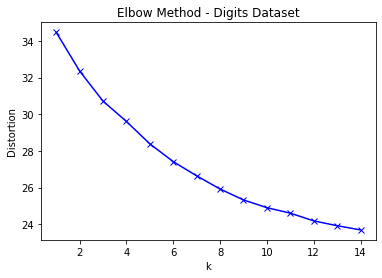

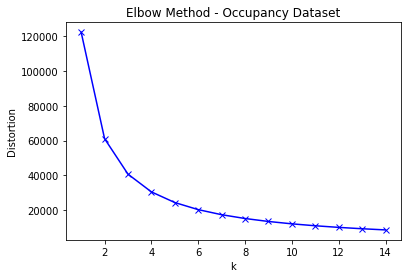

In [51]:
# Determine Best K for each Dataset using Elbow Method

# Digits Dataset
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(data)
    kmeanModel.fit(data)
    distortions.append(sum(np.min(cdist(data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title("Elbow Method - Digits Dataset")
plt.show()

# Occupancy Dataset
distortions = []
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(occData)
    kmeanModel.fit(occData)
    distortions.append(sum(np.min(cdist(occData, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / occData.shape[0])
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title("Elbow Method - Occupancy Dataset")
plt.show()

In [55]:
# Determine Best K - Silhouette Method
ss = metrics.silhouette_score

# Digits Dataset
K = range(2, 15) # Silhouette requires at least 2 labels, so one cannot be used

best_k = 0
best_silScore = -np.inf

for k in K:
    km = KMeans(n_clusters=k).fit(data)
    km.fit(data)
    score = ss(data, km.labels_)
    if score > best_silScore:
        best_silScore = score
        best_k = k
    
print(best_k)


# Occupancy Dataset
best_k = 0
best_silScore = -np.inf

for k in K:
    km = KMeans(n_clusters=k).fit(occData)
    km.fit(occData)
    score = ss(occData, km.labels_)
    if score > best_silScore:
        best_silScore = score
        best_k = k
    
print(best_k)


9
2
